# Tutorial
## See the effect of Intersectional Fairness (ISF) technology using RejectOptionClassification (ROC) and the AdultDataset
In this tutorial, we will detect the intersectional bias of the AdultDataset, improve the intersectional fairness with ISF, and demonstrate its effectiveness.  
While ISF supports several mitigation methods, we now select RejectOptionClassification and extend it for intersectional fairness.  
We will also compare ISF with ROC to explain ISF is suitable for retaining intersectional fairness.

#### RejectOptionClassification
Reject option classification is a postprocessing technique that gives favourable outcomes to unpriviliged groups and unfavourable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty.

References.  
F. Kamiran, A. Karim, and X. Zhang, “Decision Theory for Discrimination-Aware Classification,” IEEE International Conference on Data Mining, 2012.

In [1]:
%matplotlib inline

In [2]:
from pylab import rcParams

In [3]:
from aif360.algorithms.intersectional_fairness import IntersectionalFairness
from aif360.algorithms.isf_helpers.isf_utils.common import output_subgroup_metrics, convert_labels, create_multi_group_label
from aif360.algorithms.isf_helpers.isf_analysis.intersectional_bias import calc_intersectionalbias, plot_intersectionalbias_compare
from aif360.algorithms.isf_helpers.isf_analysis.metrics import check_metrics_combination_attribute, check_metrics_single_attribute

2024-08-21 11:46:26.407880: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 11:46:26.418550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 11:46:26.430318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 11:46:26.434087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 11:46:26.445493: I tensorflow/core/platform/cpu_feature_guar

In [4]:
import numpy as np
import pandas as pd

## Set up AdultDataset
Note: To download and install the AdultDataset manually, follow [README.md in AIF360](https://github.com/Trusted-AI/AIF360/tree/master/aif360/data).  

In [5]:
from aif360.datasets import AdultDataset

In [6]:
dataset = AdultDataset()
convert_labels(dataset)
ds_train, ds_test = dataset.split([0.7])

### Ensure what attributes are protected  
To verify intersectional bias, you need to specify two attributes in the Dataset as protected ones.  
AdultDataset has already specified the following two attributes as protected:  

In [7]:
dataset.protected_attribute_names

['race', 'sex']

## Classification  
We first build a classification model using ROC which is a postprocessing algorithm.  
We train a Logistic Regression model with data ds_train and then we proceed with classification for data ds_test.  

In [8]:
from sklearn.preprocessing import StandardScaler

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(ds_train.features)
y_train = ds_train.labels.ravel()
X_test = scale_orig.transform(ds_test.features)
Y_test = ds_test.labels.ravel()

In [9]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [10]:
ds_test_classified = ds_test.copy()
pos_ind = np.where(lr.classes_ == ds_train.favorable_label)[0][0]

ds_test_classified.scores = lr.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)
ds_test_classified.labels = lr.predict(X_test).reshape(-1, 1)

In [11]:
# Calculate ds_train_classified for ROC
ds_train_classified = ds_train.copy()
pos_ind = np.where(lr.classes_ == ds_train.favorable_label)[0][0]

ds_train_classified.scores = lr.predict_proba(X_train)[:, pos_ind].reshape(-1, 1)
ds_train_classified.labels = lr.predict(X_train).reshape(-1, 1)

### Confirm the model performance  
#### (1) Measure the performance for classification
Check the performance for classification using the above classification results.  

In [12]:
df_acc = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1 score'])

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
df_acc.loc['LR Model']=(
    accuracy_score(y_true=Y_test, y_pred=ds_test_classified.labels),
    precision_score(y_true=Y_test, y_pred=ds_test_classified.labels),
    recall_score(y_true=Y_test, y_pred=ds_test_classified.labels),
    f1_score(y_true=Y_test, y_pred=ds_test_classified.labels)
)

In [14]:
df_acc

,Accuracy,Precision,Recall,F1 score
LR Model,0.848824,0.744169,0.607855,0.66914


* The model achieves enough accuracy since `Accuracy` is 84%.

#### (2) Measure disparate impact to see intersectional bias caused by the combination of two attributes, `race` and `sex`
Check intersectional bias with disparate impact (DI).  

In [15]:
df_lr_di = calc_intersectionalbias(ds_test_classified, "DisparateImpact")
df_lr_di = df_lr_di.rename(columns={"DisparateImpact": "LR Model"})
df_lr_di

,LR Model
"race = 1.0,sex = 1.0",2.810223
"race = 1.0,sex = 0.0",0.352248
"race = 0.0,sex = 1.0",0.892224
"race = 0.0,sex = 0.0",0.190748


* The model requires bias mitigation because DIs for groups other than race=0.0 and sex=1.0 are out of the range for fairness. 

   Note:  
   In the recruitment field in the US, there is a law saying it is fair if the DI is 0.8 or more (and equal to or less than 1.25, the reciprocal of 0.8), so we consider 0.8 as a standard threshold of fairness.  

## Run ISF
Mitigate intersectional bias in this LR model's judgment.  
You can use the ROC algorithm, a post-processing method, for it.  Run the mitigation algorithm of ISF specifying "RejectOptionClassification" as a parameter.  

In [16]:
ID = IntersectionalFairness('RejectOptionClassification', 'DemographicParity', 
                             accuracy_metric='F1', options={'metric_ub':0.2, 'metric_lb':-0.2})

In [17]:
# training can take several minutes depending on hardware
ID.fit(ds_train, dataset_predicted=ds_train_classified)

In [18]:
# predict
ds_predicted = ID.predict(ds_test_classified)

## Evaluation

### (1) Compare the raw LR model and the model mitigated by ISF  
Measure and visualize DIs for intersectional bias to check the effect of ISF.  

In [19]:
combattr_metrics_isf = check_metrics_combination_attribute(ds_test, ds_predicted)[['base_rate', 'selection_rate', 'Balanced_Accuracy']]

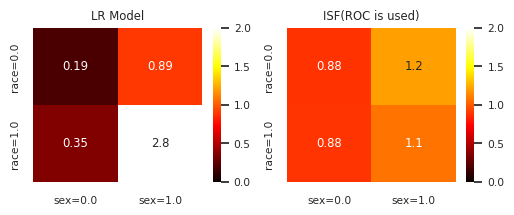

In [20]:
import seaborn as sns
rcParams['figure.figsize'] = 6,2
sns.set(font_scale = 0.7)
plot_intersectionalbias_compare(ds_test_classified,
                                ds_predicted,
                                vmax=2, vmin=0, center=1,
                                title={"right": "LR Model", "left": "ISF(ROC is used)"})

* Compared to the left-hand quadrant for the LR model with no bias mitigation, DI in each subgroup gets closer to 1.0 in the right-hand quadrant for the model mitigated by ISF.  
* This indicates that the judgment result of the model with ISF is closer to fair than that without ISF.  

Next, ensure ISF does not degrade the accuracy of the model.  

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
df_acc.loc['ISF (ROC is used)']=(accuracy_score(y_true=Y_test, y_pred=ds_predicted.labels),
                   precision_score(y_true=Y_test, y_pred=ds_predicted.labels),
                   recall_score(y_true=Y_test, y_pred=ds_predicted.labels),
                   f1_score(y_true=Y_test, y_pred=ds_predicted.labels) )

In [22]:
df_acc

,Accuracy,Precision,Recall,F1 score
LR Model,0.848824,0.744169,0.607855,0.669140
ISF (ROC is used),0.830692,0.693913,0.584701,0.634643


* `Accuracy` before and after bias mitigation are almost the same.  
* This indicates ISF can mitigate intersectional fairness with only minor accuracy degradation.  

### (2) Comparison of ROC and ISF (ROC is used)
Now compare the effects between ROC and ISF-leveraged ROC.  
Run ROC under the same condition as the ISF-leveraged ROC.  

In [23]:
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification
        
ROC = RejectOptionClassification(
            privileged_groups=[{'race':1,'sex':1}],
            unprivileged_groups=[{'race':0,'sex':0},{'race':0,'sex':1},{'race':1,'sex':0}],
            low_class_thresh=0.01, 
            high_class_thresh=0.99,
            num_class_thresh=100, 
            num_ROC_margin=50,
            metric_name='Statistical parity difference',
            metric_ub=0.2,
            metric_lb=-0.2)

In [24]:
# training
ROC.fit(ds_train, ds_train_classified)
# predict
ds_predicted_roc = ROC.predict(ds_test_classified)

#### Check intersectional bias for ROC  

In [25]:
df_roc_di =calc_intersectionalbias(ds_predicted_roc, "DisparateImpact")
df_roc_di = df_roc_di.rename(columns={"DisparateImpact": "ROC"})
df_lr_di["ROC"]=df_roc_di["ROC"]
df_lr_di

,LR Model,ROC
"race = 1.0,sex = 1.0",2.810223,1.753728
"race = 1.0,sex = 0.0",0.352248,0.538010
"race = 0.0,sex = 1.0",0.892224,1.264260
"race = 0.0,sex = 0.0",0.190748,0.324319


* Since ROC does not support intersectional bias, DI values for groups are out of the fairness range though they tend to improve.

#### Compare DI values for `ROC` and `ISF (ROC is used)`
Finally, compare DI values ordinal ROC and `ISF (ROC is used)` achieve.  

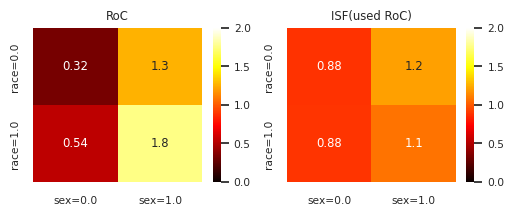

In [26]:
plot_intersectionalbias_compare(ds_predicted_roc,
                                ds_predicted,
                                vmax=2, vmin=0, center=1,
                                title={"right": "RoC", "left": "ISF(used RoC)"})

* Compared to `ROC` (the left-hand quadrant), `ISF (ROC is used)` (ROC-leveraged ISF; the right-hand quadrant) achieves a better bias mitigation.  
* We have confirmed ISF helps ROC mitigate intersectional bias.  

#### Compare accuracies for `ROC` and `ISF (ROC is used)`

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
df_acc.loc['ROC']=(
    accuracy_score(y_true=Y_test, y_pred=ds_predicted_roc.labels),
    precision_score(y_true=Y_test, y_pred=ds_predicted_roc.labels),
    recall_score(y_true=Y_test, y_pred=ds_predicted_roc.labels),
    f1_score(y_true=Y_test, y_pred=ds_predicted_roc.labels)
)

In [28]:
df_acc

,Accuracy,Precision,Recall,F1 score
LR Model,0.848824,0.744169,0.607855,0.669140
ISF (ROC is used),0.830692,0.693913,0.584701,0.634643
ROC,0.805852,0.578396,0.841149,0.685455


* Accuracies for `ISF (ROC is used)` and `ROC` are almost the same.  
* This indicates extending RoC with ISF does not cause significant accuracy degradation.  